##### LOADING PACKAGES/LIBRARIES

In [1]:
import pandas as pd
import numpy as np

In [22]:
import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt

In [4]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

##### LOADING DATA AND SETING THE DATA AS TIME SERIES

In [8]:
#### load data
worksheet = gc.open('Forecast_template').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df = df[1:]

In [17]:
### Converting the desired column to time series
df["DATE"] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
df["SALES_PRODX"] = pd.to_numeric(df["SALES_PRODX"])

In [19]:
## create time series
ts = df.groupby("DATE")["SALES_PRODX"].sum().rename("sales")
ts.head()

DATE
2007-03-31     970260
2007-06-30    1339077
2007-09-30    3035746
2007-12-31    3361822
2008-03-31    3360077
Name: sales, dtype: int64

##### IDENTIFYING STRUCTURAL CHANGES, IF WE NEED TO SPLIT THE MODEL

##### SPLITTING TRAIN AND TEST

In [20]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

--- splitting at index:  35 | 2015-12-31 00:00:00 | test size: 0.3  ---


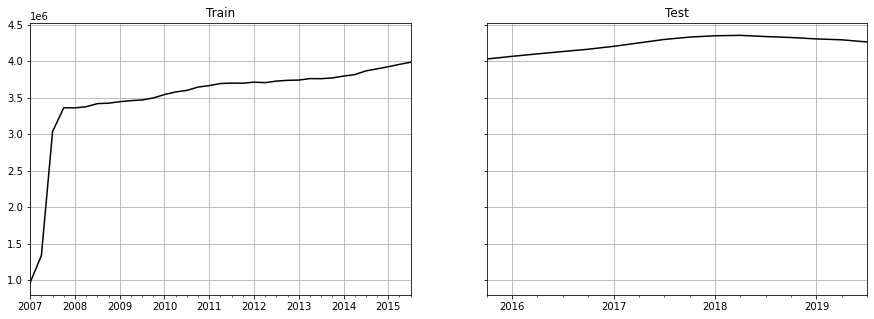

In [24]:
ts_train, ts_test = split_train_test(ts, test = 0.3)